**NOTE:** This notebook uses dimensionless equations and quantities. My Overleaf notes detail the exact scaling relations.

In [1]:
# import packages
import numpy as np
import scipy.integrate as integrate
import scipy.misc
import time
import pickle

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation

from matplotlib import cm
from matplotlib.ticker import LinearLocator
## set default plot size
plt.rcParams["figure.figsize"] = (10, 7)
## set global font size
plt.rcParams.update({'font.size':14})

import astropy.units as u
from astropy import constants as const

from scipy.interpolate import interp1d


In [2]:
# define Omega, dOmega/dJ
def Omega(J):
    '''
    
    Eq. 8 of Tremaine et al. (2023); orbital frequency.
    
    Here, we interpolate between the low-J and high-J regimes for Omega.
    The interpolated function has form a / (1 + b*J)^{1/3}. 
    
    In this function, J is dimensionless. J=1 corresponds to sigma*z_0 in
    physical units.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = a
    denom = (1 + b*J)**(1/3)
    return num / denom

def dOmega_dJ(J):
    '''
    Derivative of Omega(J), assuming that Omega(J) = a / (1 + b*J)^{1/3}. I got
    this expression for the derivative from Wolfram Alpha.
    
    '''
    
    a = 1 / np.sqrt(2)
    b = 3*np.sqrt(2) / (np.pi**2)
    
    num = -a*b/3
    denom = (1 + b*J)**(4/3)

    return num / denom

### plot Omega(J)

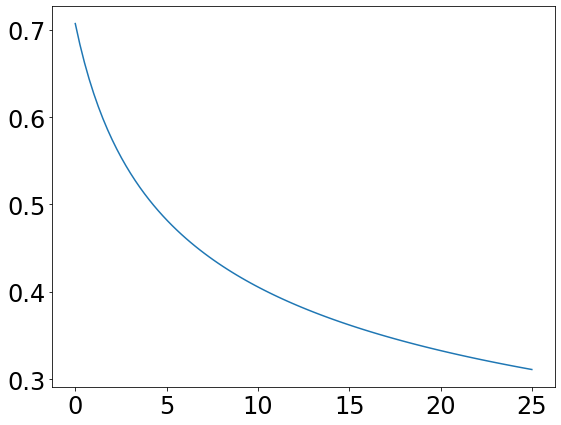

In [3]:
plt.rcParams.update({'font.size':24})

Js = np.linspace(0, 25, 100)

fig = plt.figure(figsize=(9,7))
plt.plot(Js, Omega(Js))

save_Omega_figure = False
if save_Omega_figure:
    plt.savefig(f'Gaia phase mixing (thesis)/Omega_interpolated.png', dpi=300)

Below is an approximate function for converting from action-angle to Cartesian coordinates. I also include a numerical, interpolated conversion scheme between the two coordinate systems.

In [3]:
## functions converting between (thetas, Js) and (zs, v_zs) 

def cart2pol_harmonic(z, v_z):
    '''
    Given a (z, v_z) coordinate and assuming a harmonic potential,
    return (theta, J).
    
    '''
    
    # the typical range of arctan is [-pi/2, pi/2]
    angle = z / v_z #CH: No, that's cot(theta).  
    theta = np.arctan(angle)
    if (z >= 0):
        if (v_z >= 0): # quadrant A
            theta += 0
        else: # quadrant B
            theta += np.pi
    else:
        if (v_z < 0): # quadrant C
            theta += np.pi
        else: # quadrant D
            theta += 2*np.pi
        
    J = (z**2 + v_z**2) / 2
    
    return theta, J

cart2pol_harmonic_vect = np.vectorize(cart2pol_harmonic)

def pol2cart_meshgrid_harmonic(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid in Cartesian coordinates. Assumes a 
    harmonic potential.
    
    '''
    
    zs = np.sqrt(2*Js) * np.sin(thetas) #CH: flipped sin and cos
    v_zs = np.sqrt(2*Js) * np.sin(thetas) #CH: flipped sin and cos
    
    return zs, v_zs

## load in interpolated converter functions
# AA -> CC
with open('z(theta,J)_interp.pkl', 'rb') as file:
    convert_AA_to_z = pickle.load(file)
with open('v_z(theta,J)_interp.pkl', 'rb') as file:
    convert_AA_to_vz = pickle.load(file)
# CC -> AA
with open('theta(z,v_z)_interp.pkl', 'rb') as file:
    convert_CC_to_theta = pickle.load(file)
with open('J(z,v_z)_interp.pkl', 'rb') as file:
    convert_CC_to_J = pickle.load(file)

def pol2cart_meshgrid(thetas, Js):
    '''
    Given a meshgrid of angles and actions (thetas, Js), return the 
    corresponding meshgrid (zs, v_zs) in Cartesian coordinates.
    
    '''
    
    zs = convert_AA_to_z(thetas, Js)
    v_zs = convert_AA_to_vz(thetas, Js)
    
    return zs, v_zs

# GALACTIC PHASE MIXING ANIMATION

Let's plot the time evolution of a first-order perturbation: Essentially, every particle follows a circular orbit with frequency $\Omega(J)$. This recreates the Gaia snail shape.

In [134]:
# define phase mixing (i.e., a first-order phase mixing solution for n=1)
def delta_f_phase_mixing(theta, J, t, A_0=1, t_i=0, theta_i=0):
    '''
    Eq. 1 of Tremaine et al. (2023). Suppose a generic perturbation 
    at time t_i changes the distribution function f
    by amplitude A_0. For simplicity, only consider the 
    m=1 Fourier component in theta. Then, as a function of time,
    this perturbation evolves as:
    
    delta_f(theta,J,t) = A_0 * sin[theta - Omega(J)(t-t_i) - theta_i]
    
    '''
        
    phase = theta - Omega(J)*(t-t_i) - theta_i
    
    return A_0 * np.sin(phase)

# define deltaf in a harmonic potential
def delta_f_harmonic(theta, t, A_0=1, t_i=0, theta_i=0):
    '''
    deltaf in a harmonic potential. Exhibits no phase mixing since
    omega is constant.
    
    '''
    
    omega = 0.7
    phase = theta - omega*(t-t_i) - theta_i
    
    return A_0 * np.sin(phase)

In [5]:
# ## define the hammer parameters + phase space rage
# t1, t2 = 0, 150
# n1, n2 = 1, 3
# A1, A2 = 0.01, 0.02

# # define ts, thetas, and Js; and, corresponding Cartesian coords
# # time range
# tmin = 0
# tmax = 200
# tstep = 0.5
# ts = np.arange(tmin, tmax+tstep, tstep)

# ## J=25 has z_max ~ 12 and v_max ~ 4.6, so I'll use these values as the (z, v_z) limits
# # CH: but why?  J = 0.5(v^2 + z^2), so vmax = zmax = sqrt(25/0.5) ~ 3.5?

# zlim = 12.
# vzlim = 4.6
# N_z = 400
# N_vz = 400

# zs = np.linspace(-zlim, zlim, N_z)
# v_zs = np.linspace(-vzlim, vzlim, N_vz)
# vzstep = v_zs[1] - v_zs[0]

# zs, v_zs = np.meshgrid(zs, v_zs)

# assume_harmonic_potential = False
# if assume_harmonic_potential:
#     thetas, Js = cart2pol_harmonic_vect(zs, v_zs)
# else:
#     thetas, Js = convert_CC_to_theta(zs, v_zs), convert_CC_to_J(zs, v_zs)


No handles with labels found to put in legend.


<Figure size 720x504 with 0 Axes>

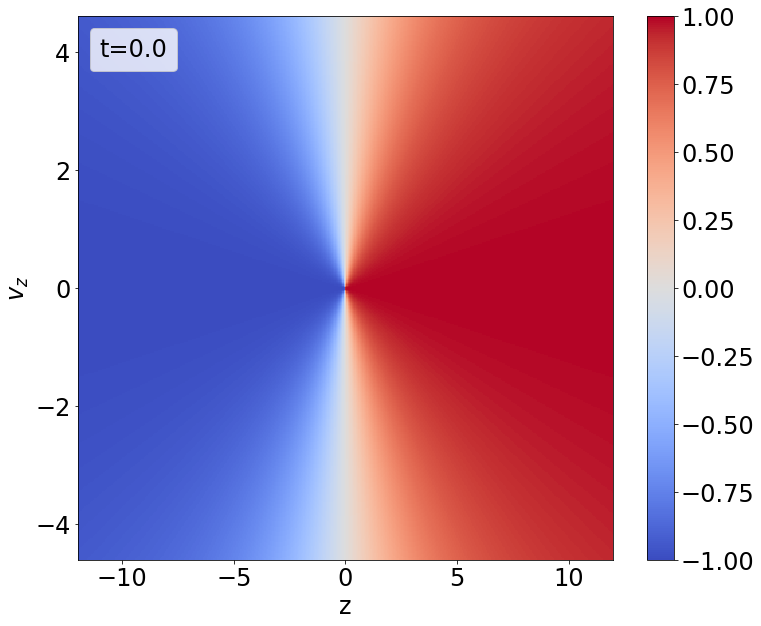

In [6]:
## plot phase mixing at 1 timepoint
plt.rcParams.update({'font.size':24})

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(12,10))

x_lim = zlim
y_lim = vzlim
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

# test that we can plot delta_f at a given t
t_temp = 0.
plot_phase_mixing = True
if plot_phase_mixing:
    Z = delta_f_phase_mixing(thetas, Js, t_temp)
else:
    Z = delta_f_harmonic(thetas, t_temp)

im = ax.pcolormesh(zs,v_zs,Z,cmap=cm.coolwarm, animated=True, shading='auto',\
                  vmin=-1, vmax=1)

fig.colorbar(im, ax=ax)

ax.set_xlabel(r"z")
ax.set_ylabel(r"$v_z$")
# ax.set_title("$\delta f$")

plt.legend(title=f"t={t_temp}", loc='upper left', labelspacing=0.)

save_pm_figure = False
if save_pm_figure:
    plt.savefig(f'Gal_harmonic_t={t_temp}.png', dpi=300)

plt.show()

### plot the slice at $z=0$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


FileNotFoundError: [Errno 2] No such file or directory: 'Gaia phase mixing (thesis)/Gal_pm_slice_t=0.png'

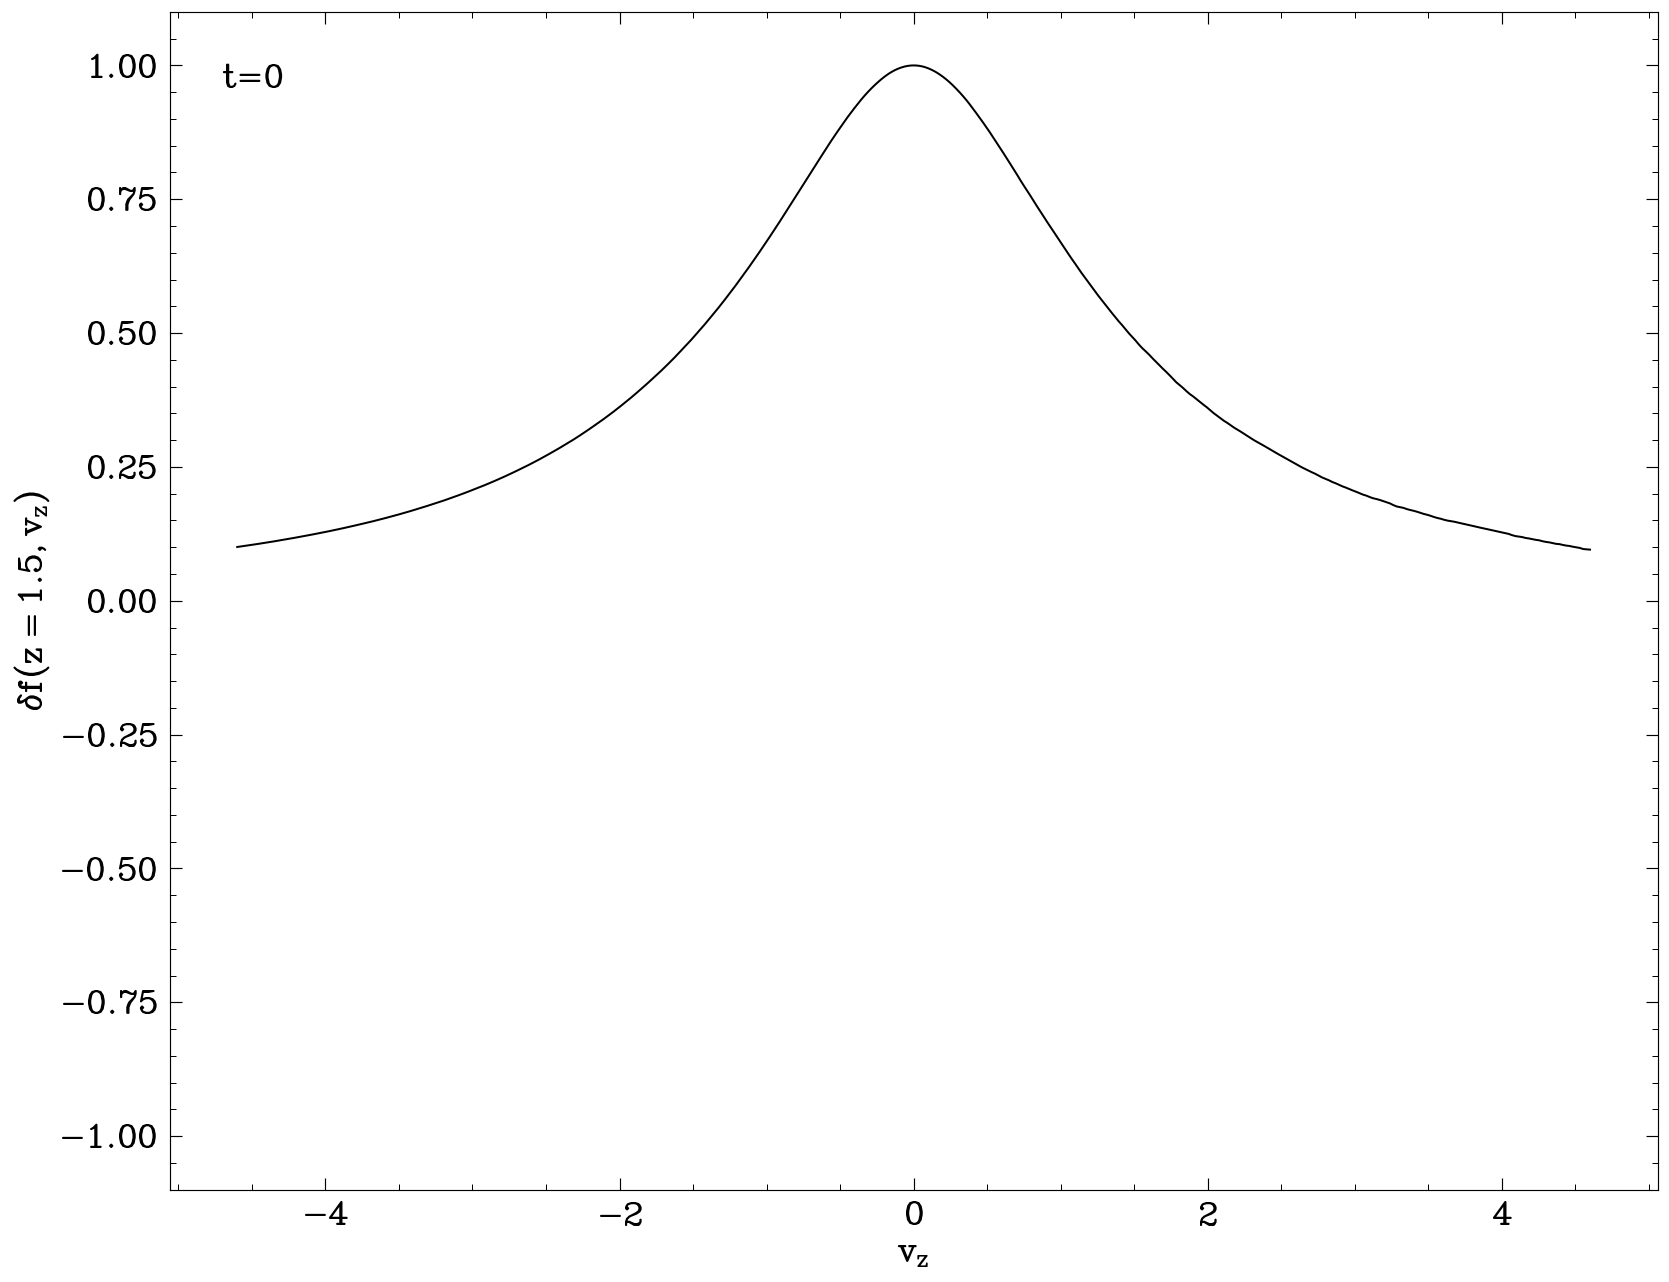

In [137]:
# plot deltaf(z=z', v_z)
plt.rcParams.update({'font.size':24})

fig, ax = plt.subplots(1,1,figsize=(16,13))

z_offset = 1.5
# find index of z_offset within zs
z_offset_ind = np.where(np.isclose(zs[0], z_offset, atol=zlim/N_z))[0][0]

t_temp = 0

# theta, J coordinates at the z=z_offset slice
assume_harmonic_potential = False
if assume_harmonic_potential:
    thetas_offset, Js_offset = \
            cart2pol_harmonic_vect(z_offset, v_zs[:,z_offset_ind])
else:
    thetas_offset = convert_CC_to_theta(z_offset, v_zs[:,z_offset_ind])
    Js_offset = convert_CC_to_J(z_offset, v_zs[:,z_offset_ind])
    
plot_phase_mixing = True
if plot_phase_mixing:
    slice_at_z = delta_f_phase_mixing(thetas_offset, Js_offset, t_temp)
else:
    slice_at_z = delta_f_harmonic(thetas_offset, t_temp)

plt.plot(v_zs[:,z_offset_ind], slice_at_z)
plt.xlabel("$v_z$")
plt.ylabel(f"$\delta f(z={z_offset}, v_z)$")
plt.ylim(-1.1, 1.1)

plt.legend(title=f"t={t_temp}", loc='upper left', labelspacing=0.)

save_fig = False
if save_fig:
    plt.savefig(f'Gaia phase mixing (thesis)/Gal_pm_slice_t={t_temp}.png', dpi=300)

plt.show()

In [ ]:
## galactic phase mixing animation
fig, ax = plt.subplots(1,1,figsize=(12,10))

Z = delta_f_phase_mixing(thetas, Js, 0)
# quad mesh
zs, v_zs = pol2cart_meshgrid(thetas, Js)
quad1 = ax.pcolormesh(zs,v_zs,Z, cmap=cm.coolwarm, animated=True, shading='auto')
fig.colorbar(quad1, ax=ax)

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$v_z$")

# the overdensity at theta=0 as a function of time; ie, delta_n(theta=0, t)
delta_n_array = []

def init():
    quad1.set_array([])
    return quad1

start = time.time()

def updatefig(num):
    # global im
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')

    Z = delta_f_phase_mixing(thetas, Js, t)
    #Z = Z[:-1, :-1]
    
    # compute integrated density
    delta_n = np.sum(Z[:, 0] * dv_zs[dv_zs_midpoint:]) # integrate over "y" at theta=0
    delta_n += np.sum(Z[:, theta_ind] * dv_zs[dv_zs_midpoint:]) # theta=pi

    delta_n_array.append(delta_n)
    
    quad1.set_array(Z.ravel())
    
    # ax.set_title('$\delta f$ (t=' + str(t) + ')')
    ax.legend(title=f"t={t_temp}", loc='upper left', labelspacing=0.)
    
    return quad1,


make_animation = True
if make_animation:
    ani = animation.FuncAnimation(fig, updatefig, interval=100, frames=len(ts), blit=True)
    ani.save("Gaia_pm_polar_temp.mp4")

In [ ]:
plt.plot(delta_n_array)
plt.title(r"$\delta n$ for phase mixing at z=0")

plt.show()

# GALACTIC ECHO ANIMATION

In [135]:
## define the slab Hamiltonian, f0, and f0's first+second derivatives
def Hamiltonian(J):
    '''
    Computes the Hamiltonian of our system by integrating Omega(J)
    from 0 to J. (Underneath Eq. 8 in Scott's paper, it's stated that
    Omega = dH/dJ.) We assume that Omega=0 for H=0.
    
    We use Omega = a/(1 + b*J)^(1/3) and its analytical antiderivative.
    
    '''
    
    term1 = np.pi**2 / 4
    b = 3*np.sqrt(2) / (np.pi**2)
    
    term2 = (1 + b*J)**(2/3)
    return term1 * term2

def f_0(J): 
    '''
    Initial distribution function of our system, using Eq. 6 of Scott's
    paper.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

def df0_dJ(J):
    '''
    The derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    We have df_0/dJ = -dH/dJ * exp(-H)/sqrt(2pi) = -Omega(J) * exp(-H)/sqrt(2pi).
    
    '''
    
    return -Omega(J) * np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

def f0_second_deriv(J):
    '''
    The second derivative of our initial distribution function, f_0(J) ~ exp(-H(J)). 
    By product rule, taking the derivative of df_0/dJ yields:
    
    -dOmega/dJ * exp(-H)/sqrt(2pi) + -Omega * [-dH/dJ * exp(-H)]/sqrt(2pi) = 
    -dOmega/dJ * exp(-H)/sqrt(2pi) + (Omega^2)*exp(-H)/sqrt(2pi) = 
    = (-dOmega/dJ + Omega^2) * exp(-H)/sqrt(2pi)
    
    '''
        
    coeff = Omega(J)**2 - dOmega_dJ(J)
    
    return coeff * np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)


## set up an f_0 function that we can use as a distribution function

def inverse_sample_decorator(dist):
    
    # for now, set our maximum J to 40
    def wrapper(pnts, x_min=0, x_max=40, n=1e5, **kwargs):
        
        x = np.linspace(x_min, x_max, int(n))
        cumulative = np.cumsum(dist(x, **kwargs))
        cumulative -= cumulative.min()
        f = interp1d(cumulative/cumulative.max(), x)
        return f(np.random.random(pnts))
    
    return wrapper

@inverse_sample_decorator
def f_0_distro(J): 
    '''
    The version of f_0(J) we use to perform inverse transform sampling.
    
    '''
    
    return np.exp(-1*Hamiltonian(J)) / np.sqrt(2 * np.pi)

## $f$ definitions

In [136]:
## define delta_f/f0 and other components of delta_f for the 2nd-order solution
def deltaf_over_f0(theta, J, t, t1, t2, n1, n2, A1, A2):
    '''
    Represents the relative distribution function delta_f / f0.
    
    '''
    
    return delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2) / f_0(J)

def f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution of the distribution function f; 
    i.e., f = f_0 + delta_f.
    
    '''
    
    return f_0(J) + delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2)

def delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the first-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    expr1 = (-2) * n1 * A1 * df0_dJ(J) * np.sin(n1 * (theta - Omega(J)*(t-t1)))
    expr2 = (-2) * n2 * A2 * df0_dJ(J) * np.sin(n2 * (theta - Omega(J)*(t-t2)))
    
    # Heaviside coefficients on each expression
    if (t < t1):
        expr1 = 0
    if (t < t2):
        expr2 = 0
    
    return expr1 + expr2


def delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2,
                 dOmega_dJ_is_zero=False):
    '''
    Represents the phase-mixing (i.e., non-echo) component of the second-order solution 
    for delta_f given two hammers: One with amplitude A1 at time t1, and one with
    amplitude A2 at time t2.
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2), defined to be 0 at 0
    if (t < t2):
        return 0
    
    t_pm = (n1*t1 + n2*t2) / (n1 + n2)
    
    # function that contains the time evolution
    xi = (n1 + n2) * (theta - Omega(J)*(t - t_pm))
        
    expr1 = (-2)*A1*A2 * np.cos(xi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(xi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2
    

def delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2,
                   dOmega_dJ_is_zero=False):
    '''
    Represents the echo component of the second-order solution for delta_f 
    given two hammers: One with amplitude A1 at time t1, and one with 
    amplitude A2 at time t2. 
    
    This formula assumes that A1 and A2 are constant; i.e., independent of J.
    
    '''
    
    # Heaviside function coefficient H(t-t_2)
    if (t < t2):
        return 0
    
    t_echo = (n2*t2 - n1*t1) / (n2 - n1)
    
    # function that contains the time evolution
    psi = (n2 - n1) * (theta - Omega(J)*(t - t_echo))
        
    expr1 = 2*A1*A2 * np.cos(psi) * n1*n2* f0_second_deriv(J)
    expr2 = (-2)*A1*A2 * np.sin(psi) * n1**2 * n2 * (t2-t1) * dOmega_dJ(J) * df0_dJ(J)
    
    # assume that dOmega_dJ = 0
    if dOmega_dJ_is_zero:
        return expr1
    
    return expr1 + expr2

def delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the second-order solution for delta_f given two hammers:
    One with amplitude A1 at time t1, and one with amplitude A2 at time t2.
    
    '''
    
    return delta_f_2_pm(theta, J, t, t1, t2, n1, n2, A1, A2) + \
                delta_f_2_echo(theta, J, t, t1, t2, n1, n2, A1, A2)


def delta_f_full(theta, J, t, t1, t2, n1, n2, A1, A2): 
    '''
    Represents the full solution to delta_f up to second order.
    
    '''
    
    return delta_f_1(theta, J, t, t1, t2, n1, n2, A1, A2) + \
            delta_f_2(theta, J, t, t1, t2, n1, n2, A1, A2)

In [137]:
## define hammer params, phase space range

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 500
n1, n2 = 1, 2
A1, A2 = 0.02, 0.01
t_echo = (n2*t2 - n1*t1) / (n2-n1)

# define ts, thetas, and Js; and, corresponding Cartesian coords
# time range
tmin = 0
tmax = t_echo * 1.3
tstep = 0.5
ts = np.arange(tmin, tmax+tstep, tstep)

## J=25 has z_max ~ 12 and v_max ~ 4.6, so I'll use these values as the (z, v_z) limits

zlim = 12.
vzlim = 4.6
N_z = 1000
N_vz = 1000

zs = np.linspace(-zlim, zlim, N_z)
v_zs = np.linspace(-vzlim, vzlim, N_vz)
vzstep = v_zs[1] - v_zs[0]

zs, v_zs = np.meshgrid(zs, v_zs)

# use exact conversion
thetas, Js = convert_CC_to_theta(zs, v_zs), convert_CC_to_J(zs, v_zs)

## plot $\delta f/f_0$ in $z,v_z$ space

No handles with labels found to put in legend.


<Figure size 720x504 with 0 Axes>

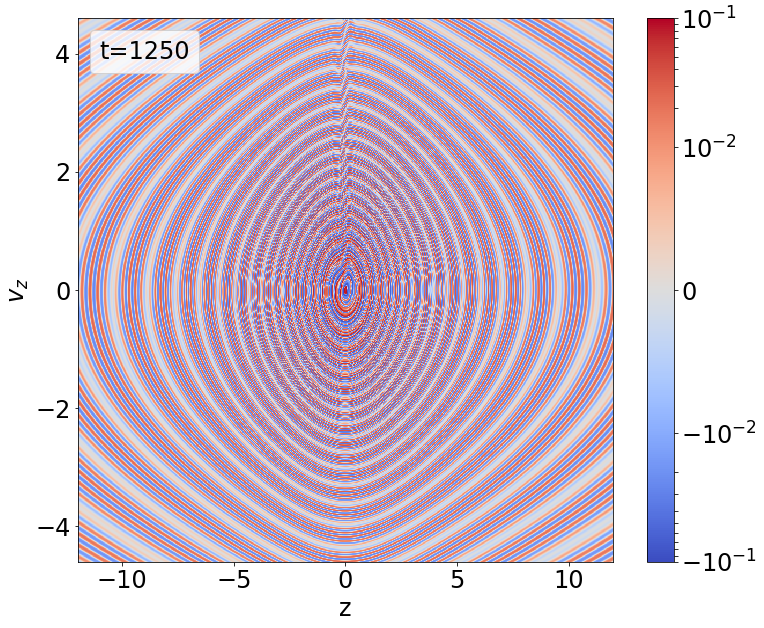

In [143]:
## plot the 2nd-order echo component at 1 timepoint
plt.rcParams.update({'font.size':24})

plt.clf()
fig, ax = plt.subplots(1,1,figsize=(12,10))

x_lim = zlim
y_lim = vzlim
plt.xlim(-x_lim, x_lim)
plt.ylim(-y_lim, y_lim)

t_temp=1250
Z = deltaf_over_f0(thetas, Js, t_temp, t1=t1, t2=t2, n1=n1, n2=n2, A1=A1, A2=A2)

vlimit=.1
im = ax.pcolormesh(zs, v_zs, Z, 
                   norm=colors.SymLogNorm(linthresh=1e-2, linscale=1,base=10,
                                          vmin=-vlimit, vmax=vlimit),\
                       cmap=cm.coolwarm,  
                   shading='auto')
cbar = fig.colorbar(im, ax=ax)

ax.set_xlabel(r"z")
ax.set_ylabel(r"$v_z$")
# ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t_temp) + ')')
ax.legend(title=f"t={t_temp}", loc='upper left', labelspacing=0.)

save_figures = True
if save_figures:
    plt.savefig(f'Galactic echo (thesis)/Gal_echo_t={t_temp}.png', dpi=300)

plt.show()

In [ ]:
## deltaf/f_0 animated in J/theta coords

fig, ax = plt.subplots(1,1,figsize=(12,10))

# initialize the color bar
Z = deltaf_over_f0(thetas, Js, 0, t1, t2, n1, n2, A1, A2)
vlimit = 1
quad1 = ax.pcolormesh(zs, v_zs, Z, 
                   norm=colors.SymLogNorm(linthresh=1e-1, linscale=1,base=10,
                                          vmin=-vlimit, vmax=vlimit),\
                       cmap=cm.coolwarm,  
                   shading='auto')
fig.colorbar(quad1, ax=ax, extend='both')

ax.set_xlabel(r"$z$")
ax.set_ylabel(r"$v_z$")

def init():
    quad1.set_array([])
    return quad1

start = time.time()
def updatefig(num):
    
    t = ts[num]
    if ((t % 10) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    Z = deltaf_over_f0(thetas, Js, t, t1, t2, n1, n2, A1, A2)
    
    ## plot delta_f in J vs. theta phase space
    #Z = Z[:-1, :-1]
    quad1.set_array(Z.ravel())
    
    #ax.set_title('$\delta f \, / \, f_0$ (t=' + str(t) + ')')
    ax.legend(title=f"t={t_temp}", loc='upper left', labelspacing=0.)

    return im,

make_animation = False
if make_animation:
    ani = animation.FuncAnimation(fig, updatefig, frames=len(ts), interval=100, blit=True)
    ani.save("deltaf_over_f0_temp.mp4")

In [125]:
# calculate the overdensity at z=z_offset as a function of time; ie, delta_n(z=z_offset)

# import smplotlib

# define the parameters of the two hammers (t_i, n_i, A_i)
t1, t2 = 0, 500
n1, n2 = 1, 2
A1, A2 = 0.02, 0.01
t_echo = (n2*t2 - n1*t1) / (n2-n1)

# define ts, thetas, and Js; and, corresponding Cartesian coords
# time range
tmin = 0
tmax = t_echo * 1.3
tstep = 1.
ts = np.arange(tmin, tmax+tstep, tstep)


start = time.time()
delta_n_over_ns = []

delta_n_1_over_ns = []
delta_n_2_over_ns = []

delta_n_2_echo_over_ns = []
delta_n_2_pm_over_ns = []

z_offset = 0.48
# find index of z_offset within zs
z_offset_ind = np.where(np.isclose(zs[0], z_offset, atol=1.1*zlim/N_z))[0][0]


# theta, J coordinates at the z=z_offset slice, using exact conversion
thetas_offset = convert_CC_to_theta(z_offset, v_zs[:,z_offset_ind])
Js_offset = convert_CC_to_J(z_offset, v_zs[:,z_offset_ind])

    
for t in ts:
    if ((t % 200) == 0):
        print("t = " + str(t))
        print(f'Elapsed t: {np.round(time.time() - start, 1)} seconds')
        
    deltan_over_n0 = np.sum(delta_f_full(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f_0(Js_offset))
    deltan_1_over_n0 = np.sum(delta_f_1(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f_0(Js_offset))
    deltan_2_over_n0 = np.sum(delta_f_2(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f_0(Js_offset))
    deltan_2_echo_over_n0 = np.sum(delta_f_2_echo(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f_0(Js_offset))
    deltan_2_pm_over_n0 = np.sum(delta_f_2_pm(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f_0(Js_offset))
    
    delta_n_over_ns.append(deltan_over_n0)
    delta_n_1_over_ns.append(deltan_1_over_n0)
    delta_n_2_over_ns.append(deltan_2_over_n0)
    delta_n_2_echo_over_ns.append(deltan_2_echo_over_n0)
    delta_n_2_pm_over_ns.append(deltan_2_pm_over_n0)

    
    #deltan_over_n0 = np.sum(delta_f_full(thetas_offset, Js_offset, t, t1, t2, n1, n2, A1, A2)) / np.sum(f0(Js_offset))


t = 0.0
Elapsed t: 0.0 seconds
t = 200.0
Elapsed t: 0.3 seconds
t = 400.0
Elapsed t: 0.5 seconds
t = 600.0
Elapsed t: 1.0 seconds
t = 800.0
Elapsed t: 1.9 seconds
t = 1000.0
Elapsed t: 2.7 seconds
t = 1200.0
Elapsed t: 3.7 seconds


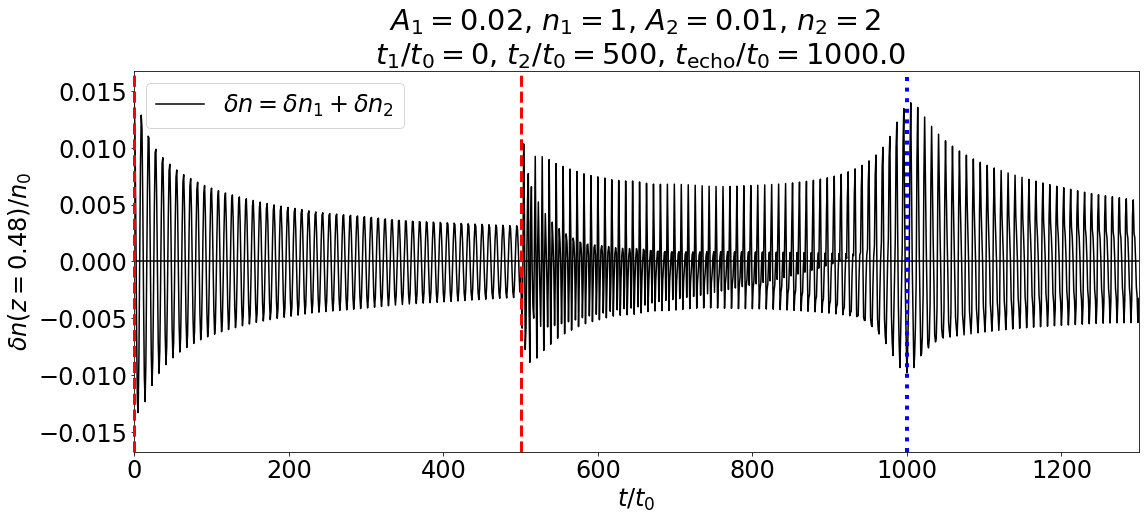

In [126]:
# density at x_val=0
plt.rcParams.update({'font.size':24})
fig = plt.subplots(1,1,figsize=(18,7))

#plt.plot(ts, delta_n_1_over_ns, label='$\delta n_1$', zorder=1, color='green', linestyle='--')
#plt.plot(ts, delta_n_2_echo_over_ns, label='$\delta n_2^\mathrm{{echo}}$', zorder=10, linestyle=':',color='orange')
#plt.plot(ts, delta_n_2_pm_over_ns, label='$\delta n_2^\mathrm{{pm}}$', zorder=8, linestyle=':', color='cyan')
# plt.plot(ts, delta_n_2_over_ns, label='$\delta n_2 = \delta n_2^\mathrm{{echo}} + \delta n_2^\mathrm{{pm}}$', zorder=6, linestyle='--', color='red')
plt.plot(ts, delta_n_over_ns, label='$\delta n = \delta n_1 + \delta n_2$', zorder=0, color='k')
# plt.title(r'$\delta n$ at $\sqrt{J} \cos(\theta) = 0$')

plt.xlabel('$t/t_0$')
plt.xlim(tmin, tmax)
plt.ylabel(f'$\delta n(z={z_offset}) / n_0$')
plt.title(f'$A_1={A1}$, $n_1 = {n1}$, $A_2={A2}$, $n_2={n2}$ \n $t_1/t_0=0$, $t_2/t_0={t2}$, $t_\mathrm{{echo}}/t_0={t_echo}$')

deltan_min = min(delta_n_over_ns)
deltan_max = max(delta_n_over_ns)
ylim = np.abs(np.max((deltan_min, deltan_max))) # make y-axis symmetric around 0
ymin = -ylim*1.2
ymax = ylim*1.2
plt.ylim(ymin, ymax)
#plt.xlim()

plt.hlines(0, tmin, tmax, colors='black')
plt.vlines([t_echo], ymin, ymax, colors='blue', linestyles=':', linewidth=4)
plt.vlines([t1], ymin, ymax, colors='red', linestyles='--', linewidth=3, zorder=10,clip_on=False)
plt.vlines([t2], ymin, ymax, colors='red', linestyles='--', linewidth=3)
plt.legend(loc='best', ncol=2)

#plt.text(200,-0.04,f'$t_1/t_0=0$ \n $t_2/t_0={t2}$ \n $t_\mathrm{{echo}}/t_0={t_echo}$')


save_fig = False
if save_fig:
    #plt.savefig('Galactic echo/two_hammers_deltan_over_n0_temp.png')
    plt.savefig(f'deltan_over_n0_z={z_offset}.png', dpi=300)

plt.show()

# np.save("delta_n_array", delta_n_array)

In [110]:
plt.vlines?

In [10]:
# t after t2 where delta_n peaks 
# (the +2 offset is needed because delta_n_array has 2 extra terms at the start, idk why)
second_hammer_t = (int) (t2 / tstep)
print("delta n peaks at this t:")
ts[np.argmax(np.abs(delta_n_over_ns[(second_hammer_t+2):]))]+t2

delta n peaks at this t:


600.75

### maximum $z$ for the problematic region

This is the region near the origin where particles will be pushed to $J<0$ in the numerical simulations.

In [118]:
Delta_J_max = 2*n1*A1 + 2*n2*A2
thetas_temp = np.linspace(0, 2*np.pi, 100)

print('upper bound on z of problematic gap:')
np.max(np.abs(convert_AA_to_z(thetas_temp, Delta_J_max)))

upper bound on z of problematic gap:


0.4786530108336589

## ECHO PLOT 1: echo (w/ separate components) vs. system w/ no echo

## ECHO PLOT 2: echo at 4 different $z$'s